# An example of benchmark result analysis with GAMA
This notebook contains visualizations from results obtained by GAMA on the AutoML benchmark.

In [2]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

In [3]:
regression_1h = pd.read_csv(r"http://openml-test.win.tue.nl/amlb/latest/regression_1h8c.csv")
regression_4h = pd.read_csv(r"http://openml-test.win.tue.nl/amlb/latest/regression_4h8c.csv")
classification_1h = pd.read_csv(r"http://openml-test.win.tue.nl/amlb/latest/classification_1h8c.csv")
classification_4h = pd.read_csv(r"http://openml-test.win.tue.nl/amlb/latest/classification_4h8c.csv")

In [33]:
comparison_frameworks = ["GAMA", "GAMA_benchmark", "TunedRandomForest", "TPOT", "AutoGluon_benchmark"]
framework_colors = dict(zip(comparison_frameworks, ["#c41616", "#cc648e", "#2ba110", "#174bb3", "#e0a226"]))
comparison = regression_1h[regression_1h["framework"].isin(comparison_frameworks)]

In [34]:
comparison = comparison.sort_values(by="utc", na_position="first")
# Use only the latest results (earlier failures don't count, only justified reruns are done)
comparison = comparison.drop_duplicates(["framework", "task", "fold"], keep="last")

Text(0.5, 1.0, 'Subset of 1 Hour Regression Results')

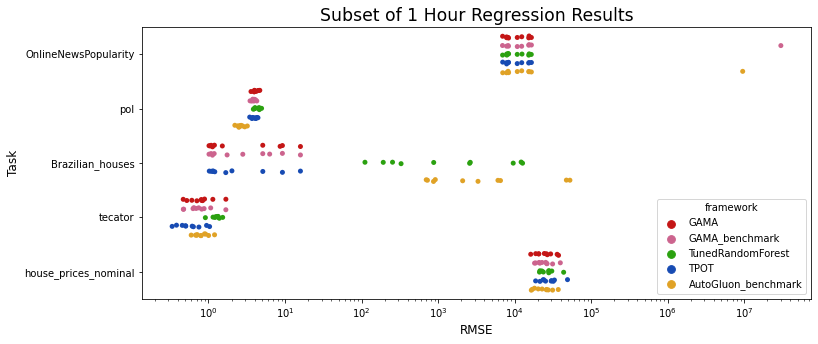

In [40]:
comparison = comparison[comparison.task.isin(["pol", "OnlineNewsPopularity", "Brazilian_houses", "tecator", "house_prices_nominal"])]
fig, ax = plt.subplots(1, 1, figsize=(12, len(comparison.task.unique())))
seaborn.stripplot(
    data=comparison, x="rmse", y="task",
    hue="framework", hue_order=comparison_frameworks, palette=framework_colors,
    dodge=True,  ax=ax
)
ax.set_xscale("log")
ax.set_xlabel("RMSE", size='large')
ax.set_ylabel("Task", size='large')
ax.set_title("Subset of 1 Hour Regression Results", size='xx-large')

## Online News Popularity

We see outliers in `OnlineNewsPopularity`, and find this is in fold 7:

In [83]:
comparison[(comparison["framework"] == "GAMA_benchmark") & (comparison["task"] == "OnlineNewsPopularity")].sort_values("rmse", ascending=False).head(2)[["task", "fold", "result"]]

,task,fold,result
1688,OnlineNewsPopularity,7,-29967000.0
1410,OnlineNewsPopularity,6,-16526.2


We can then have a closer look at the errors of the predictions of `GAMA_ensemble`, here we contrast it with the `GAMA_single` errors:

Text(0.5, 1.0, 'Abs Errors Ensemble v. Single')

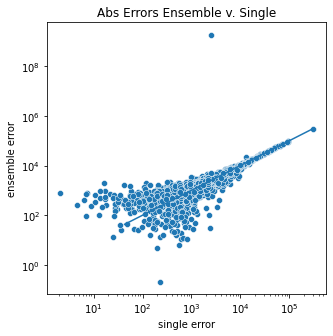

In [84]:
ensemble_pred = pd.read_csv("http://openml-test.win.tue.nl/amlb/automlbenchmark/regression_1h8c/gama_benchmark.openml_s_269.1h8c_gp3.aws.20211203T192317/aws.openml_s_269.1h8c_gp3.onlinenewspopularity.7.gama_benchmark/output/predictions/OnlineNewsPopularity/7/predictions.csv")
single_pred = pd.read_csv("http://openml-test.win.tue.nl/amlb/automlbenchmark/regression_1h8c/gama.openml_s_269.1h8c_gp3.aws.20211116T234341/aws.openml_s_269.1h8c_gp3.onlinenewspopularity.7.gama/output/predictions/OnlineNewsPopularity/7/predictions.csv")
assert (ensemble_pred["truth"] == single_pred["truth"]).all()

ensemble = pd.read_csv("http://openml-test.win.tue.nl/amlb/automlbenchmark/regression_1h8c/gama_benchmark.openml_s_269.1h8c_gp3.aws.20211203T192317/aws.openml_s_269.1h8c_gp3.onlinenewspopularity.7.gama_benchmark/output/logs/OnlineNewsPopularity/7/evaluations.log", sep=';')
single = pd.read_csv("http://openml-test.win.tue.nl/amlb/automlbenchmark/regression_1h8c/gama.openml_s_269.1h8c_gp3.aws.20211116T234341/aws.openml_s_269.1h8c_gp3.onlinenewspopularity.7.gama/output/logs/OnlineNewsPopularity/7/evaluations.log", sep=';')

df = ensemble_pred.copy()
df["single_err"] = abs(single_pred["truth"] - single_pred["predictions"])
df["ensemble_err"] = abs(ensemble_pred["truth"] - ensemble_pred["predictions"])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
seaborn.scatterplot(data=df, x="single_err", y="ensemble_err", ax=ax)
seaborn.lineplot(data=df, x="truth", y="truth", ax=ax)
ax.set_xscale("log")
ax.set_xlabel("single error")
ax.set_yscale("log")
ax.set_ylabel("ensemble error")
ax.set_title("Abs Errors Ensemble v. Single")

We notice there is one single large error. Below, we observe that this is from a prediction with a negative number and that when it is clamped, the RMSE is in line with that of `GAMA_single`:

In [97]:
print("Results for individual predictions:")
ensemble_pred["error"] = abs(ensemble_pred["truth"] - ensemble_pred["predictions"])
print("Top 2 largest errors:")
print(ensemble_pred.sort_values("error", ascending=False).head(2), end = '\n\n')
print("Top 2 smallest predictions:")
print(ensemble_pred.sort_values("predictions").head(2), end = '\n\n')

def rmse(y, y_hat, clamp = lambda i: i):
    return math.sqrt(sum((y - y_hat.apply(clamp))**2) / len(y))

print("We find there is a single negative prediction, and it causes the largest error by orders of magnitude. Below we examine the effect of setting that prediction to 0.")

print("\nResults for aggregate scores:")
print("RMSE Ensemble:", rmse(ensemble_pred["truth"], ensemble_pred["predictions"]))
print("RMSE Ensemble (non-negative):", rmse(ensemble_pred["truth"], ensemble_pred["predictions"], clamp = lambda x: max(x, 0)))
print("RMSE Single (non-negative):", rmse(single_pred["truth"], single_pred["predictions"]))

Results for individual predictions:
Top 2 largest errors:
       predictions     truth         error
1995 -1.886727e+09    5900.0  1.886732e+09
1093  6.594616e+03  310800.0  3.042054e+05

Top 2 smallest predictions:
       predictions   truth         error
1995 -1.886727e+09  5900.0  1.886732e+09
810   1.322392e+03   900.0  4.223923e+02

We find there is a single negative prediction, and it causes the largest error by orders of magnitude. Below we examine the effect of setting that prediction to 0.

Results for aggregate scores:
RMSE Ensemble: 29967016.30740964
RMSE Ensemble (non-negative): 7847.952141516465
RMSE Single (non-negative): 7836.819190109789


So the ensemble made a single mistake that explains the large outlier by itself. 
We can have a closer look at the ensemble to see what could be the cause. 
Below, we see that the ensemble seemed to optimize internal score really well: 139,604,800 $\rightarrow$ 79,892,638.
The ensemble consists almost exclusively out of tree-based models, except for two `LinearSVR` pipelines.
Since the tree-based models can't extrapolate (and negative target values don't exist in the dataset), these should be the culprits.
```
[...] Building ensemble.
[...] Not downsampling because only 10000 samples were stored.
[...] Weight RobustScaler>RandomForestRegressor set to 1.
[...] Weight VarianceThreshold>ExtraTreesRegressor set to 1.
[...] Weight VarianceThreshold>RandomForestRegressor set to 1.
[...] Weight VarianceThreshold>ExtraTreesRegressor set to 1.
[...] Weight RandomForestRegressor set to 1.
[...] Weight RandomForestRegressor set to 1.
[...] Weight RandomForestRegressor set to 1.
[...] Weight Normalizer>RandomForestRegressor set to 1.
[...] Weight VarianceThreshold>RandomForestRegressor set to 1.
[...] Weight VarianceThreshold>ExtraTreesRegressor set to 1.
[...] Initial ensemble created with score -80246705.12774952
[...] Weight Binarizer>ExtraTreesRegressor set to 1.
[...] Ensemble size 11 , best score: -80147801.5010803
[...] Weight Binarizer>Normalizer>RandomForestRegressor set to 1.
[...] Ensemble size 12 , best score: -80090255.05118471
[...] Weight GradientBoostingRegressor set to 1.
[...] Ensemble size 13 , best score: -80041932.72658312
[...] Weight Binarizer>LinearSVR set to 1.
[...] Ensemble size 14 , best score: -80008001.16550504
[...] Weight PCA>RobustScaler>ExtraTreesRegressor set to 1.
[...] Ensemble size 15 , best score: -79986277.457813
[...] Weight VarianceThreshold>FastICA>RandomForestRegressor set to 1.
[...] Ensemble size 16 , best score: -79969473.52279343
[...] Weight Binarizer>Normalizer>RandomForestRegressor set to 2.
[...] Ensemble size 17 , best score: -79954104.27954839
[...] Weight GradientBoostingRegressor set to 2.
[...] Ensemble size 18 , best score: -79938301.21069105
[...] Weight PCA>RobustScaler>ExtraTreesRegressor set to 2.
[...] Ensemble size 19 , best score: -79927357.5133368
[...] Weight FastICA>LinearSVR set to 1.
[...] Ensemble size 20 , best score: -79919788.8546862
[...] Weight Binarizer>Normalizer>RandomForestRegressor set to 3.
[...] Ensemble size 21 , best score: -79913373.48947339
[...] Weight VarianceThreshold>FastICA>RandomForestRegressor set to 2.
[...] Ensemble size 22 , best score: -79907407.56858316
[...] Weight GradientBoostingRegressor set to 3.
[...] Ensemble size 23 , best score: -79902979.94687271
[...] Weight Binarizer>Normalizer>RandomForestRegressor set to 4.
[...] Ensemble size 24 , best score: -79896784.50083311
[...] Weight PCA>RobustScaler>ExtraTreesRegressor set to 3.
[...] Ensemble size 25 , best score: -79892638.62896185
[...] Ensemble build took 6.071673154830933s. 
[...] STOP: postprocess EnsemblePostProcessing after 7.3576s.
```

We can also inspect how well these pipelines performed individually, e.g., the best of each regressor:

In [113]:
ensemble = pd.read_csv("http://openml-test.win.tue.nl/amlb/automlbenchmark/regression_1h8c/gama_benchmark.openml_s_269.1h8c_gp3.aws.20211203T192317/aws.openml_s_269.1h8c_gp3.onlinenewspopularity.7.gama_benchmark/output/logs/OnlineNewsPopularity/7/evaluations.log", sep=';')
ensemble["rmse"] = ensemble["score"].apply(lambda s: float(s[1:-1].split(',')[0]))
ensemble["rank"] = ensemble["rmse"].rank(ascending=False)
ensemble["regressor"] = ensemble.pipeline.apply(lambda p: p.split('(')[0])

print(len(ensemble), "pipelines evaluated during search")
ensemble.sort_values("rank", inplace=True)
ensemble.drop_duplicates(["regressor"], keep="first").head(10)[["rank", "rmse", "regressor"]]


301 pipelines evaluated during search


,rank,rmse,regressor
223,1.0,-1.396048e+08,RandomForestRegressor
232,2.0,-1.396540e+08,ExtraTreesRegressor
58,66.0,-1.403929e+08,LassoLarsCV
168,73.0,-1.404038e+08,ElasticNetCV
102,77.0,-1.404638e+08,LinearSVR
278,89.0,-1.406813e+08,GradientBoostingRegressor
235,102.0,-1.408925e+08,AdaBoostRegressor
125,148.5,-1.415781e+08,DecisionTreeRegressor
261,156.0,-1.418062e+08,KNeighborsRegressor


While `LinearSVR` is only ranked 77 of 301, but the RMSE is relatively speaking not bad.
We can now start thinking about how to solve this issue, e.g., try to discover feature semantics and incorporate them in the final model (and/or use a different method altogether, like stacking).

 - OnlineNewsPopularity: Fold 7 (for both autogluon and GAMA)
 - Tecator: Fold 3 (in both cases)

## Tecator

We see outliers in `Tecator`, and find this is in fold 3:

In [116]:
comparison[((comparison["framework"] == "GAMA_benchmark") | (comparison["framework"] == "GAMA")) & (comparison["task"] == "tecator")].sort_values("rmse", ascending=False).head(4)[["task", "fold", "framework", "result"]]

,task,fold,framework,result
4424,tecator,3,GAMA,-1.68805
1467,tecator,3,GAMA_benchmark,-1.68659
4452,tecator,5,GAMA,-1.14029
1672,tecator,5,GAMA_benchmark,-1.06920


We can then have a closer look at the errors of the predictions. 
We can see if the errors are correlated:

Text(0.5, 1.0, 'Abs Errors Ensemble v. Single')

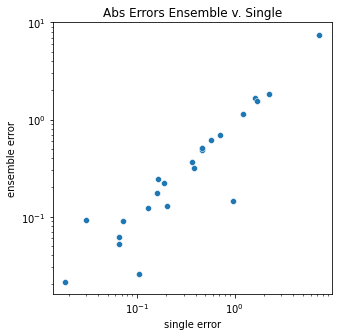

In [123]:
ensemble_pred = pd.read_csv("http://openml-test.win.tue.nl/amlb/automlbenchmark/regression_1h8c/gama_benchmark.openml_s_269.1h8c_gp3.aws.20211203T192317/aws.openml_s_269.1h8c_gp3.tecator.3.gama_benchmark/output/predictions/tecator/3/predictions.csv")
single_pred = pd.read_csv("http://openml-test.win.tue.nl/amlb/automlbenchmark/regression_1h8c/gama.openml_s_269.1h8c_gp3.aws.20211116T113915/aws.openml_s_269.1h8c_gp3.tecator.3.gama/output/predictions/tecator/3/predictions.csv")
assert (ensemble_pred["truth"] == single_pred["truth"]).all()

ensemble = pd.read_csv("http://openml-test.win.tue.nl/amlb/automlbenchmark/regression_1h8c/gama_benchmark.openml_s_269.1h8c_gp3.aws.20211203T192317/aws.openml_s_269.1h8c_gp3.tecator.3.gama_benchmark/output/logs/tecator/3/evaluations.log", sep=';')
single = pd.read_csv("http://openml-test.win.tue.nl/amlb/automlbenchmark/regression_1h8c/gama.openml_s_269.1h8c_gp3.aws.20211116T113915/aws.openml_s_269.1h8c_gp3.tecator.3.gama/output/logs/tecator/3/evaluations.log", sep=';')
df = ensemble_pred.copy()
df["single_err"] = abs(single_pred["truth"] - single_pred["predictions"])
df["ensemble_err"] = abs(ensemble_pred["truth"] - ensemble_pred["predictions"])

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
seaborn.scatterplot(data=df, x="single_err", y="ensemble_err", ax=ax)
#seaborn.lineplot(data=df, x="truth", y="truth", ax=ax)
ax.set_xscale("log")
ax.set_xlabel("single error")
ax.set_yscale("log")
ax.set_ylabel("ensemble error")
ax.set_title("Abs Errors Ensemble v. Single")

We notice there is one single large error. Below, we observe that this is from a prediction with a negative number and that when it is clamped, the RMSE is in line with that of `GAMA_single`:

In [97]:
ensemble_pred = pd.read_csv("http://openml-test.win.tue.nl/amlb/automlbenchmark/regression_1h8c/gama_benchmark.openml_s_269.1h8c_gp3.aws.20211203T192317/aws.openml_s_269.1h8c_gp3.onlinenewspopularity.7.gama_benchmark/output/predictions/OnlineNewsPopularity/7/predictions.csv")
single_pred = pd.read_csv("http://openml-test.win.tue.nl/amlb/automlbenchmark/regression_1h8c/gama.openml_s_269.1h8c_gp3.aws.20211116T234341/aws.openml_s_269.1h8c_gp3.onlinenewspopularity.7.gama/output/predictions/OnlineNewsPopularity/7/predictions.csv")
assert (ensemble_pred["truth"] == single_pred["truth"]).all()

print("Results for individual predictions:")
ensemble_pred["error"] = abs(ensemble_pred["truth"] - ensemble_pred["predictions"])
print("Top 2 largest errors:")
print(ensemble_pred.sort_values("error", ascending=False).head(2), end = '\n\n')
print("Top 2 smallest predictions:")
print(ensemble_pred.sort_values("predictions").head(2), end = '\n\n')

def rmse(y, y_hat, clamp = lambda i: i):
    return math.sqrt(sum((y - y_hat.apply(clamp))**2) / len(y))

print("We find there is a single negative prediction, and it causes the largest error by orders of magnitude. Below we examine the effect of setting that prediction to 0.")

print("\nResults for aggregate scores:")
print("RMSE Ensemble:", rmse(ensemble_pred["truth"], ensemble_pred["predictions"]))
print("RMSE Ensemble (non-negative):", rmse(ensemble_pred["truth"], ensemble_pred["predictions"], clamp = lambda x: max(x, 0)))
print("RMSE Single (non-negative):", rmse(single_pred["truth"], single_pred["predictions"]))

Results for individual predictions:
Top 2 largest errors:
       predictions     truth         error
1995 -1.886727e+09    5900.0  1.886732e+09
1093  6.594616e+03  310800.0  3.042054e+05

Top 2 smallest predictions:
       predictions   truth         error
1995 -1.886727e+09  5900.0  1.886732e+09
810   1.322392e+03   900.0  4.223923e+02

We find there is a single negative prediction, and it causes the largest error by orders of magnitude. Below we examine the effect of setting that prediction to 0.

Results for aggregate scores:
RMSE Ensemble: 29967016.30740964
RMSE Ensemble (non-negative): 7847.952141516465
RMSE Single (non-negative): 7836.819190109789


So the ensemble made a single mistake that explains the large outlier by itself. 
We can have a closer look at the ensemble to see what could be the cause. 
Below, we see that the ensemble seemed to optimize internal score really well: 139,604,800 $\rightarrow$ 79,892,638.
The ensemble consists almost exclusively out of tree-based models, except for two `LinearSVR` pipelines.
Since the tree-based models can't extrapolate (and negative target values don't exist in the dataset), these should be the culprits.
```
[...] Building ensemble.
[...] Not downsampling because only 10000 samples were stored.
[...] Weight RobustScaler>RandomForestRegressor set to 1.
[...] Weight VarianceThreshold>ExtraTreesRegressor set to 1.
[...] Weight VarianceThreshold>RandomForestRegressor set to 1.
[...] Weight VarianceThreshold>ExtraTreesRegressor set to 1.
[...] Weight RandomForestRegressor set to 1.
[...] Weight RandomForestRegressor set to 1.
[...] Weight RandomForestRegressor set to 1.
[...] Weight Normalizer>RandomForestRegressor set to 1.
[...] Weight VarianceThreshold>RandomForestRegressor set to 1.
[...] Weight VarianceThreshold>ExtraTreesRegressor set to 1.
[...] Initial ensemble created with score -80246705.12774952
[...] Weight Binarizer>ExtraTreesRegressor set to 1.
[...] Ensemble size 11 , best score: -80147801.5010803
[...] Weight Binarizer>Normalizer>RandomForestRegressor set to 1.
[...] Ensemble size 12 , best score: -80090255.05118471
[...] Weight GradientBoostingRegressor set to 1.
[...] Ensemble size 13 , best score: -80041932.72658312
[...] Weight Binarizer>LinearSVR set to 1.
[...] Ensemble size 14 , best score: -80008001.16550504
[...] Weight PCA>RobustScaler>ExtraTreesRegressor set to 1.
[...] Ensemble size 15 , best score: -79986277.457813
[...] Weight VarianceThreshold>FastICA>RandomForestRegressor set to 1.
[...] Ensemble size 16 , best score: -79969473.52279343
[...] Weight Binarizer>Normalizer>RandomForestRegressor set to 2.
[...] Ensemble size 17 , best score: -79954104.27954839
[...] Weight GradientBoostingRegressor set to 2.
[...] Ensemble size 18 , best score: -79938301.21069105
[...] Weight PCA>RobustScaler>ExtraTreesRegressor set to 2.
[...] Ensemble size 19 , best score: -79927357.5133368
[...] Weight FastICA>LinearSVR set to 1.
[...] Ensemble size 20 , best score: -79919788.8546862
[...] Weight Binarizer>Normalizer>RandomForestRegressor set to 3.
[...] Ensemble size 21 , best score: -79913373.48947339
[...] Weight VarianceThreshold>FastICA>RandomForestRegressor set to 2.
[...] Ensemble size 22 , best score: -79907407.56858316
[...] Weight GradientBoostingRegressor set to 3.
[...] Ensemble size 23 , best score: -79902979.94687271
[...] Weight Binarizer>Normalizer>RandomForestRegressor set to 4.
[...] Ensemble size 24 , best score: -79896784.50083311
[...] Weight PCA>RobustScaler>ExtraTreesRegressor set to 3.
[...] Ensemble size 25 , best score: -79892638.62896185
[...] Ensemble build took 6.071673154830933s. 
[...] STOP: postprocess EnsemblePostProcessing after 7.3576s.
```

We can also inspect how well these pipelines performed individually, e.g., the best of each regressor:

In [113]:
ensemble = pd.read_csv("http://openml-test.win.tue.nl/amlb/automlbenchmark/regression_1h8c/gama_benchmark.openml_s_269.1h8c_gp3.aws.20211203T192317/aws.openml_s_269.1h8c_gp3.onlinenewspopularity.7.gama_benchmark/output/logs/OnlineNewsPopularity/7/evaluations.log", sep=';')
ensemble["rmse"] = ensemble["score"].apply(lambda s: float(s[1:-1].split(',')[0]))
ensemble["rank"] = ensemble["rmse"].rank(ascending=False)
ensemble["regressor"] = ensemble.pipeline.apply(lambda p: p.split('(')[0])

print(len(ensemble), "pipelines evaluated during search")
ensemble.sort_values("rank", inplace=True)
ensemble.drop_duplicates(["regressor"], keep="first").head(10)[["rank", "rmse", "regressor"]]


301 pipelines evaluated during search


,rank,rmse,regressor
223,1.0,-1.396048e+08,RandomForestRegressor
232,2.0,-1.396540e+08,ExtraTreesRegressor
58,66.0,-1.403929e+08,LassoLarsCV
168,73.0,-1.404038e+08,ElasticNetCV
102,77.0,-1.404638e+08,LinearSVR
278,89.0,-1.406813e+08,GradientBoostingRegressor
235,102.0,-1.408925e+08,AdaBoostRegressor
125,148.5,-1.415781e+08,DecisionTreeRegressor
261,156.0,-1.418062e+08,KNeighborsRegressor


While `LinearSVR` is only ranked 77 of 301, but the RMSE is relatively speaking not bad.
We can now start thinking about how to solve this issue, e.g., try to discover feature semantics and incorporate them in the final model (and/or use a different method altogether, like stacking).

,rank,rmse,regressor
223,1.0,-1.396048e+08,RandomForestRegressor
232,2.0,-1.396540e+08,ExtraTreesRegressor
58,66.0,-1.403929e+08,LassoLarsCV
168,73.0,-1.404038e+08,ElasticNetCV
102,77.0,-1.404638e+08,LinearSVR


Plans:
 - recover evaluations.log of the specific fold and 3 other random ones, 
 - plot in 2x2 internal validation scores and population composition
 

Can we learn more maybe about why performance is less from ensembling in house price? If internal searches were less successful maybe it was too big to overcome.

## A closer look at outlier folds: OnlineNewsPopularity.7 and Tecator.3

In [99]:
ensemble = pd.read_csv("http://openml-test.win.tue.nl/amlb/automlbenchmark/regression_1h8c/gama_benchmark.openml_s_269.1h8c_gp3.aws.20211203T192317/aws.openml_s_269.1h8c_gp3.onlinenewspopularity.7.gama_benchmark/output/logs/OnlineNewsPopularity/7/evaluations.log", sep=';')
ensemble["rank"] = ensemble["rmse"].rank(ascending=False)
ensemble.sort_values("rank").head()

single = pd.read_csv("http://openml-test.win.tue.nl/amlb/automlbenchmark/regression_1h8c/gama.openml_s_269.1h8c_gp3.aws.20211116T234341/aws.openml_s_269.1h8c_gp3.onlinenewspopularity.7.gama/output/logs/OnlineNewsPopularity/7/evaluations.log", sep=';')

def add_rmse(df):
    df["rmse"] = df["score"].apply(lambda s: float(s[1:-1].split(',')[0]))
add_rmse(ensemble)
add_rmse(single)

In [105]:
pd.set_option('display.max_colwidth', None)


,id,pid,t_start,t_wallclock,t_process,score,pipeline,error,parent0,parent1,origin,rmse,rank
223,47dc6a32-f9e5-4da2-a3d0-fa3da8482c9a,60,"2021-12-03 20:44:24,106388",36.586897,36.580401,"(-139604810.51889265, -2)","RandomForestRegressor(RobustScaler(data), RandomForestRegressor.bootstrap=False, RandomForestRegressor.max_features=0.05, RandomForestRegressor.min_samples_leaf=10, RandomForestRegressor.min_samples_split=12, RandomForestRegressor.n_estimators=100)",None,d8a8c9a5-664a-43e1-83a0-ee91627f8af0,NaN,mut_replace_primitive,-1.396048e+08,1.0
232,d108c777-ba13-42bf-a359-e70fffb9e665,62,"2021-12-03 20:45:41,589968",18.327396,17.978946,"(-139654005.86659658, -2)","ExtraTreesRegressor(VarianceThreshold(data, VarianceThreshold.threshold=0.8), ExtraTreesRegressor.bootstrap=True, ExtraTreesRegressor.max_features=0.6000000000000001, ExtraTreesRegressor.min_samples_leaf=18, ExtraTreesRegressor.min_samples_split=6, ExtraTreesRegressor.n_estimators=100)",None,15ca29ca-6fa2-4334-94ee-1fe30459e690,NaN,mut_replace_primitive,-1.396540e+08,2.0
228,6f331d03-cc47-42fc-986f-e2a795cc8570,56,"2021-12-03 20:45:15,063427",20.600909,20.594396,"(-139709307.50543576, -2)","RandomForestRegressor(VarianceThreshold(data, VarianceThreshold.threshold=0.8), RandomForestRegressor.bootstrap=False, RandomForestRegressor.max_features=0.05, RandomForestRegressor.min_samples_leaf=10, RandomForestRegressor.min_samples_split=12, RandomForestRegressor.n_estimators=100)",None,d8a8c9a5-664a-43e1-83a0-ee91627f8af0,fbf9890f-cbfc-4aa4-a28d-2b6a69d26918,cx,-1.397093e+08,3.0
281,185389a6-694a-43c2-8463-1c8f23e44a94,55,"2021-12-03 20:52:33,599509",17.921354,17.871111,"(-139755616.09851626, -2)","ExtraTreesRegressor(VarianceThreshold(data, VarianceThreshold.threshold=0.8), ExtraTreesRegressor.bootstrap=True, ExtraTreesRegressor.max_features=0.6000000000000001, ExtraTreesRegressor.min_samples_leaf=17, ExtraTreesRegressor.min_samples_split=10, ExtraTreesRegressor.n_estimators=100)",None,fbf9890f-cbfc-4aa4-a28d-2b6a69d26918,NaN,mut_replace_primitive,-1.397556e+08,4.0
279,5d61629a-da98-47e8-a235-b07289745af2,62,"2021-12-03 20:50:25,639754",121.401556,120.967296,"(-139778602.1048716, -1)","RandomForestRegressor(data, RandomForestRegressor.bootstrap=False, RandomForestRegressor.max_features=0.15000000000000002, RandomForestRegressor.min_samples_leaf=16, RandomForestRegressor.min_samples_split=9, RandomForestRegressor.n_estimators=100)",None,c9de8eff-be5a-408b-bdd7-7b6704ce7db1,NaN,mut_replace_terminal,-1.397786e+08,5.0


In [56]:
single.sort_values("rmse", ascending=False).head()[["rmse", "pipeline"]]

,rmse,pipeline
350,-1.398532e+08,"ExtraTreesRegressor(data, ExtraTreesRegressor.bootstrap=False, ExtraTreesRegressor.max_features=0.8, ExtraTreesRegressor.min_samples_leaf=20, ExtraTreesRegressor.min_samples_split=14, ExtraTreesRegressor.n_estimators=100)"
276,-1.398624e+08,"ExtraTreesRegressor(MaxAbsScaler(data), ExtraTreesRegressor.bootstrap=False, ExtraTreesRegressor.max_features=0.45, ExtraTreesRegressor.min_samples_leaf=20, ExtraTreesRegressor.min_samples_split=5, ExtraTreesRegressor.n_estimators=100)"
378,-1.398628e+08,"ExtraTreesRegressor(data, ExtraTreesRegressor.bootstrap=True, ExtraTreesRegressor.max_features=0.7000000000000001, ExtraTreesRegressor.min_samples_leaf=20, ExtraTreesRegressor.min_samples_split=4, ExtraTreesRegressor.n_estimators=100)"
334,-1.398783e+08,"ExtraTreesRegressor(data, ExtraTreesRegressor.bootstrap=False, ExtraTreesRegressor.max_features=0.3, ExtraTreesRegressor.min_samples_leaf=20, ExtraTreesRegressor.min_samples_split=14, ExtraTreesRegressor.n_estimators=100)"
277,-1.398837e+08,"ExtraTreesRegressor(MaxAbsScaler(data), ExtraTreesRegressor.bootstrap=False, ExtraTreesRegressor.max_features=0.45, ExtraTreesRegressor.min_samples_leaf=20, ExtraTreesRegressor.min_samples_split=11, ExtraTreesRegressor.n_estimators=100)"


We see that very similar pipelines are found. Let's verify ensembling worked as expected:

Ensemble seemed to optimize internal score really well: 139,604,800 $\rightarrow$ 79,892,638
```
[2021-12-03 20:55:34,958 - gama.postprocessing.ensemble] Building ensemble.
[2021-12-03 20:55:34,959 - gama.postprocessing.ensemble] Not downsampling because only 10000 samples were stored.
[2021-12-03 20:55:40,195 - gama.postprocessing.ensemble] Weight RobustScaler>RandomForestRegressor set to 1.
[2021-12-03 20:55:40,195 - gama.postprocessing.ensemble] Weight VarianceThreshold>ExtraTreesRegressor set to 1.
[2021-12-03 20:55:40,195 - gama.postprocessing.ensemble] Weight VarianceThreshold>RandomForestRegressor set to 1.
[2021-12-03 20:55:40,195 - gama.postprocessing.ensemble] Weight VarianceThreshold>ExtraTreesRegressor set to 1.
[2021-12-03 20:55:40,195 - gama.postprocessing.ensemble] Weight RandomForestRegressor set to 1.
[2021-12-03 20:55:40,195 - gama.postprocessing.ensemble] Weight RandomForestRegressor set to 1.
[2021-12-03 20:55:40,195 - gama.postprocessing.ensemble] Weight RandomForestRegressor set to 1.
[2021-12-03 20:55:40,195 - gama.postprocessing.ensemble] Weight Normalizer>RandomForestRegressor set to 1.
[2021-12-03 20:55:40,196 - gama.postprocessing.ensemble] Weight VarianceThreshold>RandomForestRegressor set to 1.
[2021-12-03 20:55:40,196 - gama.postprocessing.ensemble] Weight VarianceThreshold>ExtraTreesRegressor set to 1.
[2021-12-03 20:55:40,196 - gama.postprocessing.ensemble] Initial ensemble created with score -80246705.12774952
[2021-12-03 20:55:40,253 - gama.postprocessing.ensemble] Weight Binarizer>ExtraTreesRegressor set to 1.
[2021-12-03 20:55:40,253 - gama.postprocessing.ensemble] Ensemble size 11 , best score: -80147801.5010803
[2021-12-03 20:55:40,309 - gama.postprocessing.ensemble] Weight Binarizer>Normalizer>RandomForestRegressor set to 1.
[2021-12-03 20:55:40,309 - gama.postprocessing.ensemble] Ensemble size 12 , best score: -80090255.05118471
[2021-12-03 20:55:40,365 - gama.postprocessing.ensemble] Weight GradientBoostingRegressor set to 1.
[2021-12-03 20:55:40,365 - gama.postprocessing.ensemble] Ensemble size 13 , best score: -80041932.72658312
[2021-12-03 20:55:40,420 - gama.postprocessing.ensemble] Weight Binarizer>LinearSVR set to 1.
[2021-12-03 20:55:40,420 - gama.postprocessing.ensemble] Ensemble size 14 , best score: -80008001.16550504
[2021-12-03 20:55:40,475 - gama.postprocessing.ensemble] Weight PCA>RobustScaler>ExtraTreesRegressor set to 1.
[2021-12-03 20:55:40,475 - gama.postprocessing.ensemble] Ensemble size 15 , best score: -79986277.457813
[2021-12-03 20:55:40,530 - gama.postprocessing.ensemble] Weight VarianceThreshold>FastICA>RandomForestRegressor set to 1.
[2021-12-03 20:55:40,530 - gama.postprocessing.ensemble] Ensemble size 16 , best score: -79969473.52279343
[2021-12-03 20:55:40,585 - gama.postprocessing.ensemble] Weight Binarizer>Normalizer>RandomForestRegressor set to 2.
[2021-12-03 20:55:40,585 - gama.postprocessing.ensemble] Ensemble size 17 , best score: -79954104.27954839
[2021-12-03 20:55:40,641 - gama.postprocessing.ensemble] Weight GradientBoostingRegressor set to 2.
[2021-12-03 20:55:40,641 - gama.postprocessing.ensemble] Ensemble size 18 , best score: -79938301.21069105
[2021-12-03 20:55:40,696 - gama.postprocessing.ensemble] Weight PCA>RobustScaler>ExtraTreesRegressor set to 2.
[2021-12-03 20:55:40,696 - gama.postprocessing.ensemble] Ensemble size 19 , best score: -79927357.5133368
[2021-12-03 20:55:40,751 - gama.postprocessing.ensemble] Weight FastICA>LinearSVR set to 1.
[2021-12-03 20:55:40,751 - gama.postprocessing.ensemble] Ensemble size 20 , best score: -79919788.8546862
[2021-12-03 20:55:40,807 - gama.postprocessing.ensemble] Weight Binarizer>Normalizer>RandomForestRegressor set to 3.
[2021-12-03 20:55:40,807 - gama.postprocessing.ensemble] Ensemble size 21 , best score: -79913373.48947339
[2021-12-03 20:55:40,862 - gama.postprocessing.ensemble] Weight VarianceThreshold>FastICA>RandomForestRegressor set to 2.
[2021-12-03 20:55:40,862 - gama.postprocessing.ensemble] Ensemble size 22 , best score: -79907407.56858316
[2021-12-03 20:55:40,918 - gama.postprocessing.ensemble] Weight GradientBoostingRegressor set to 3.
[2021-12-03 20:55:40,918 - gama.postprocessing.ensemble] Ensemble size 23 , best score: -79902979.94687271
[2021-12-03 20:55:40,974 - gama.postprocessing.ensemble] Weight Binarizer>Normalizer>RandomForestRegressor set to 4.
[2021-12-03 20:55:40,974 - gama.postprocessing.ensemble] Ensemble size 24 , best score: -79896784.50083311
[2021-12-03 20:55:41,029 - gama.postprocessing.ensemble] Weight PCA>RobustScaler>ExtraTreesRegressor set to 3.
[2021-12-03 20:55:41,029 - gama.postprocessing.ensemble] Ensemble size 25 , best score: -79892638.62896185
[2021-12-03 20:55:41,029 - gama.postprocessing.ensemble] Ensemble build took 6.071673154830933s. Fit with timeout 1074.9003393650055s.
```

Look at predictions:

In [58]:
ensemble_pred = pd.read_csv("http://openml-test.win.tue.nl/amlb/automlbenchmark/regression_1h8c/gama_benchmark.openml_s_269.1h8c_gp3.aws.20211203T192317/aws.openml_s_269.1h8c_gp3.onlinenewspopularity.7.gama_benchmark/output/predictions/OnlineNewsPopularity/7/predictions.csv")
single_pred = pd.read_csv("http://openml-test.win.tue.nl/amlb/automlbenchmark/regression_1h8c/gama.openml_s_269.1h8c_gp3.aws.20211116T234341/aws.openml_s_269.1h8c_gp3.onlinenewspopularity.7.gama/output/predictions/OnlineNewsPopularity/7/predictions.csv")
assert (ensemble_pred["truth"] == single_pred["truth"]).all()

Text(0.5, 1.0, 'Abs Errors Ensemble v. Single')

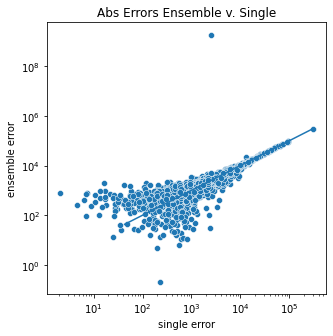

In [79]:
# fig, axes = plt.subplots(1, 1, figsize=(5, 5))
# seaborn.scatterplot(data=ensemble_pred, x="predictions", y="truth", ax=axes[0])
# seaborn.lineplot(data=ensemble_pred, x="truth", y="truth", ax=axes[0])
# axes[0].set_xscale("log")
# axes[0].set_xlabel("prediction")
# axes[0].set_yscale("log")
# axes[0].set_ylabel("truth")
# axes[0].set_title("Ensemble")
# seaborn.scatterplot(data=single_pred, x="predictions", y="truth", ax=axes[1])
# seaborn.lineplot(data=single_pred, x="truth", y="truth", ax=axes[1])
# axes[1].set_xscale("log")
# axes[1].set_xlabel("prediction")
# axes[1].set_yscale("log")
# axes[1].set_ylabel("truth")
# axes[1].set_title("Best Fit")
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
axes = [None, None, ax]  # for compatibility with disabled code.
df = ensemble_pred.copy()
df["single_err"] = abs(single_pred["truth"] - single_pred["predictions"])
df["ensemble_err"] = abs(ensemble_pred["truth"] - ensemble_pred["predictions"])
seaborn.scatterplot(data=df, x="single_err", y="ensemble_err", ax=axes[2])
seaborn.lineplot(data=df, x="truth", y="truth", ax=axes[2])
axes[2].set_xscale("log")
axes[2].set_xlabel("single error")
axes[2].set_yscale("log")
axes[2].set_ylabel("ensemble error")
axes[2].set_title("Abs Errors Ensemble v. Single")


In [78]:
df.sort_values("truth", ascending=True).head()

,predictions,truth,single_err,ensemble_err
2470,1836.125285,43.0,1487.617483,1793.125285
3266,2267.027307,47.0,1482.156141,2220.027307
1241,1989.554212,59.0,1593.878404,1930.554212
3510,2756.903982,64.0,2334.325188,2692.903982
1996,2417.523755,70.0,1961.551121,2347.523755


In [76]:
import math
rmse = math.sqrt(sum((ensemble_pred["truth"] - ensemble_pred["predictions"].apply(lambda x: max(x, 0)))**2) / len(ensemble_pred))
rmse

7847.952141516465

In [72]:
comparison[comparison.framework.isin(["GAMA", "GAMA_benchmark"]) & (comparison["task"] == "OnlineNewsPopularity") & (comparison["fold"] == 7)]

,id,task,framework,constraint,fold,type,result,metric,mode,version,...,duration,training_duration,predict_duration,models_count,seed,info,mae,r2,rmse,models_ensemble_count
1886,openml.org/t/359941,OnlineNewsPopularity,GAMA,1h8c_gp3,7,regression,-7836.82,neg_rmse,aws.docker,21.0.0,...,3265.6,3253.5,0.1,50.0,2053126056,NaN,2888.92,4.676260e-02,7836.82,NaN
1688,openml.org/t/359941,OnlineNewsPopularity,GAMA_benchmark,1h8c_gp3,7,regression,-29967000.00,neg_rmse,aws.docker,21.0.1,...,2544.8,2527.2,6.1,50.0,700650433,NaN,478922.00,-1.393830e+07,29967000.00,NaN


In [70]:
rmse

29967016.30740964